In [9]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 
import etv_functions_trapezoid  # trapezoid model 

from importlib import reload

%matplotlib inline

In [10]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 371165722


In [11]:
# define the plotting parameters

figsize = (8,4)

In [12]:
# import the data

# choose a TIC ID to analyze
ticid = 371165722

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_trapezoid_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_trapezoid_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lcc_tess = sr.download_all()
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 20,2019,SPOC,120,371165722,0.0,G022253
1,TESS Sector 44,2021,SPOC,120,371165722,0.0,"G04157 , G04171"
2,TESS Sector 45,2021,SPOC,120,371165722,0.0,"G04157 , G04171"
3,TESS Sector 47,2021,SPOC,120,371165722,0.0,"G04157 , G04171"
4,TESS Sector 60,2022,SPOC,120,371165722,0.0,"G05024 , G05003"
5,TESS Sector 71,2023,SPOC,120,371165722,0.0,"G06057 , G06022 , G06023 , G06022 , G06023"
6,TESS Sector 72,2023,SPOC,120,371165722,0.0,"G06057 , G06022 , G06023 , G06022 , G06023"


120166

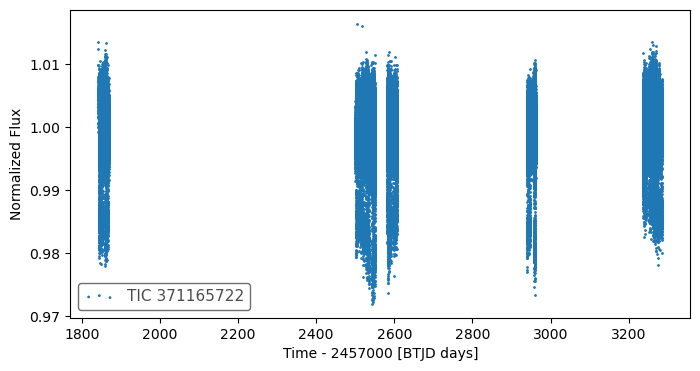

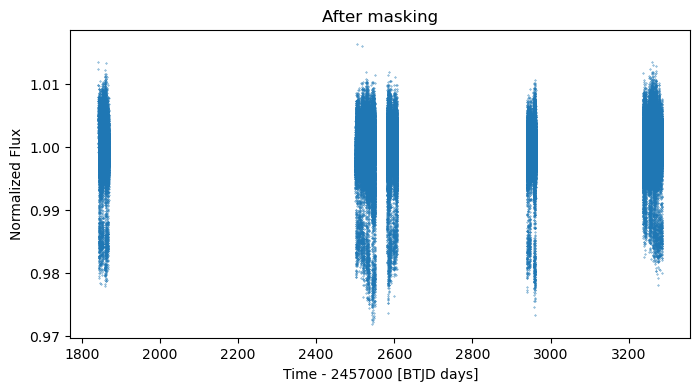

In [13]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [14]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [15]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

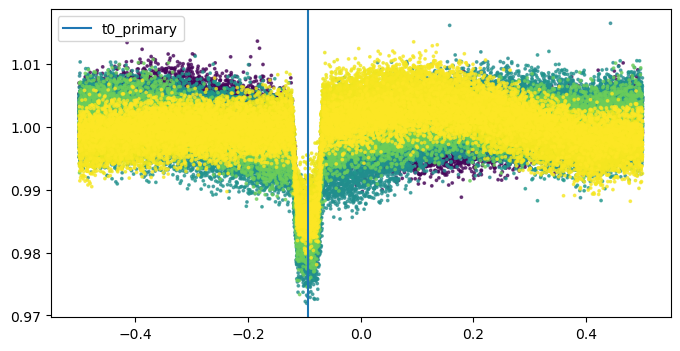

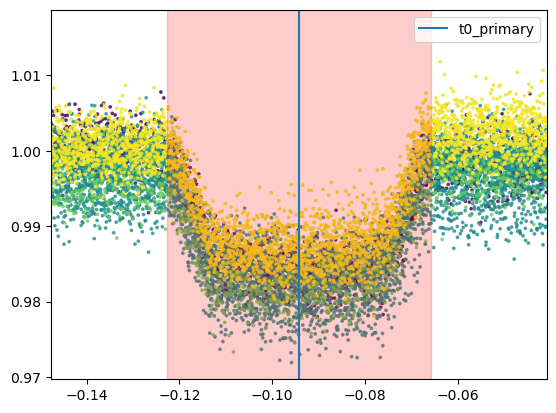

In [16]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1842.7721, duration_hr=3.0798, period=2.250286, label="s0002-s0072:TCE1",
# VSX: 2.25024 
# MCMC on df_primary: 

# FILL-IN THE eclipse epoch / period, 
period = 2.250286

t0_primary = 1842.7721
t0_secondary = None # there is actually secondary, at `t0_primary + 1.125` , from TCE1, but it's so shallow (along with the variation outside eclipses) such that it is probably futile to model it 


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 3.0798 
duration_hr_secondary = 3

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
data["flux_original"] = data["flux"]  # keep a copy of original data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 4, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
    plt.legend();
    # plt.ylim(0.75, 0.85);
    plt.show()

In [ ]:
# use detrended flux 
data.flux = data.flux_detrended
print("Detrended flux is used for ETV analysis.")

### Now that the data is ready we can start 

Primary:   1842.7721 -0.09426979503942057
window_width_p (phase): 0.06843130162121615


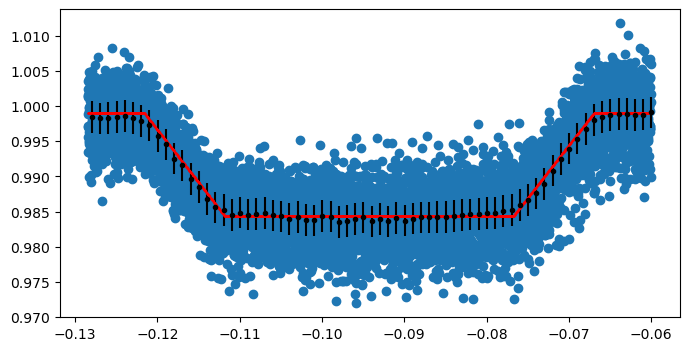

In [69]:
reload(etv_functions)
reload(etv_functions_trapezoid)

# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.2 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.2 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# val_constant, amplitude, t0, bottom_width, slope
# median flux, eclipse depth, t0, 
# t0 in normalixed phase
start_vals = [0.999, 0.0147, midpoint_p, 0.035, 1.5]

# start_vals_s = [1.00, -0.42, midpoint_s, 0.015, 0.9]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions_trapezoid.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions_trapezoid.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

In [ ]:
# use MCMC to refine the period
# Not available for trapezoid fit for now


emcee parallel enabled, use 4 CPUs.
DBG  start_vals: [0.999, 0.0147, -0.09426979503942057, 0.035, 1.5]
DBG  len(pos) 128 pos[0] [ 0.99901253  0.01469375 -0.09425644  0.03499086  1.50000618]


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.79it/s]


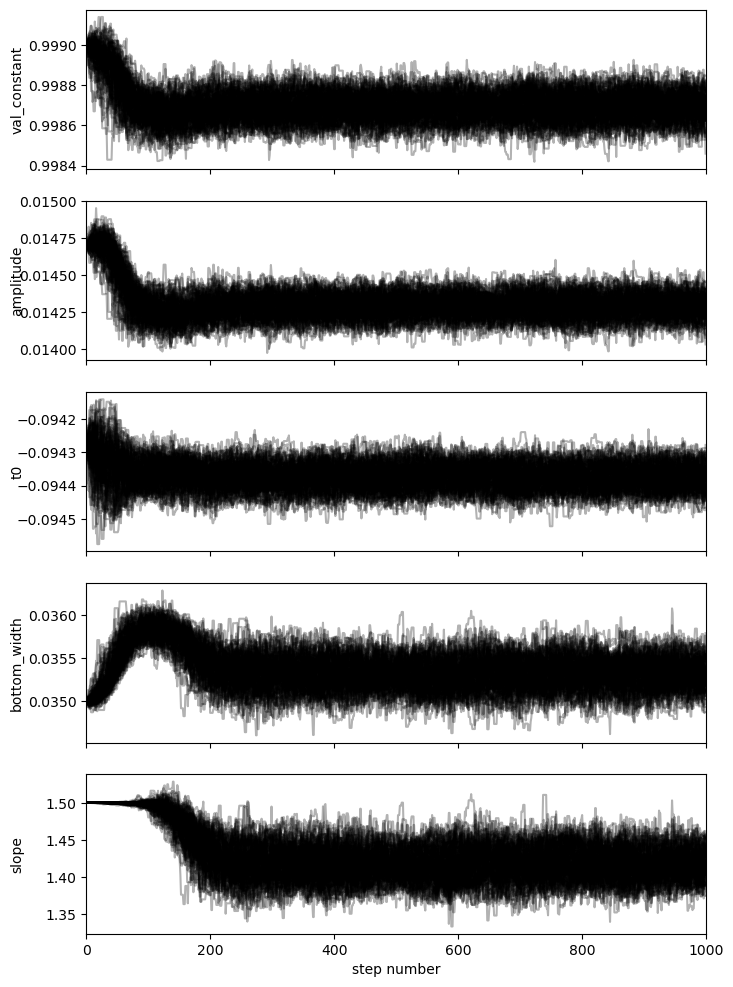

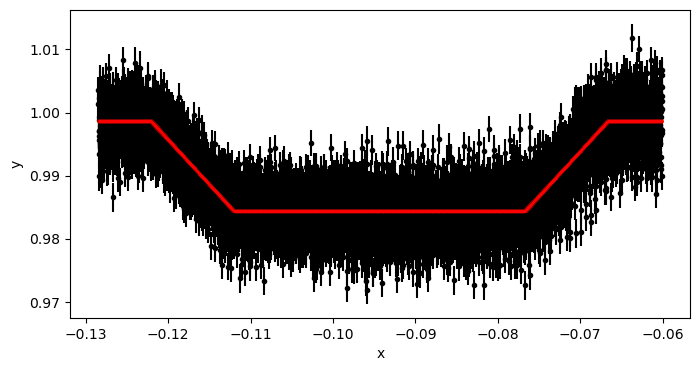

In [34]:
reload(etv_functions_trapezoid)

# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_val_constant, mean_amplitude, mean_t0, mean_bottom_width, mean_slope = etv_functions_trapezoid.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, discard=600, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_val_constant_s, mean_amplitude_s, mean_t0_s, mean_bottom_width_s, mean_slope_s, = etv_functions_trapezoid.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [72]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data, first run, with nruns=1000,
    mean_val_constant, mean_amplitude, mean_t0, mean_bottom_width, mean_slope = 0.9986928039394569, 0.014292437687910782, -0.09437324237797519, 0.0353297137918583, 1.4169969531565338
    
    etv_functions_trapezoid.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_val_constant, mean_amplitude, mean_t0, mean_bottom_width, mean_slope])
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [42]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_val_constant, mean_amplitude, mean_t0, mean_bottom_width, mean_slope = " + ", ".join([str(v) for v in [mean_val_constant, mean_amplitude, mean_t0, mean_bottom_width, mean_slope]]))
if t0_secondary is not None:
    print("mean_val_constant_s, mean_amplitude_s, mean_t0_s, mean_bottom_width_s, mean_slope_s = " + ", ".join([str(v) for v in [mean_val_constant_s, mean_amplitude_s, mean_t0_s, mean_bottom_width_s, mean_slope_s]]))

Initial model params:
mean_val_constant, mean_amplitude, mean_t0, mean_bottom_width, mean_slope = 0.9986928039394569, 0.014292437687910782, -0.09437324237797519, 0.0353297137918583, 1.4169969531565338


641

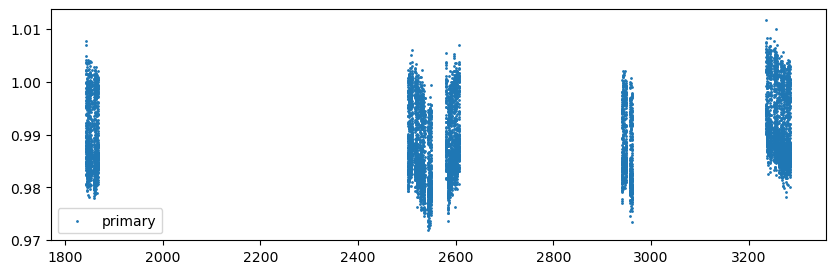

In [43]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1842.7721 2.250286 1842.7721


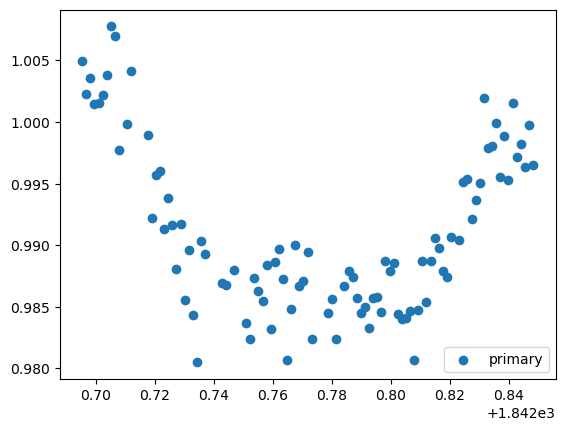

1842.7721 2.250286 1845.0223859999999


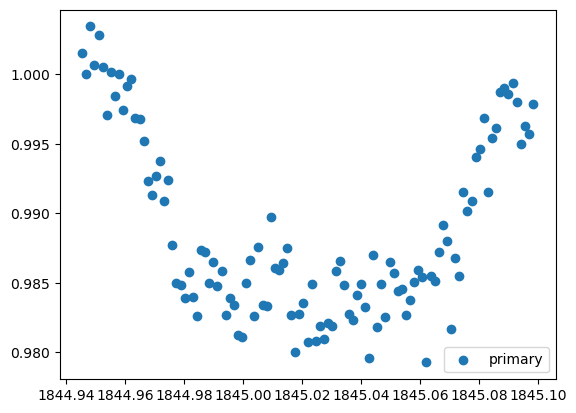

1842.7721 2.250286 1847.2726719999998


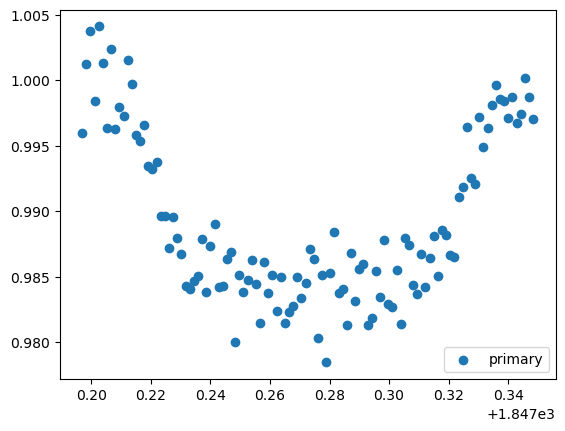

In [44]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 7 has already been completed -- skip
1860.7743879999998 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:03<00:00, 158.08it/s]


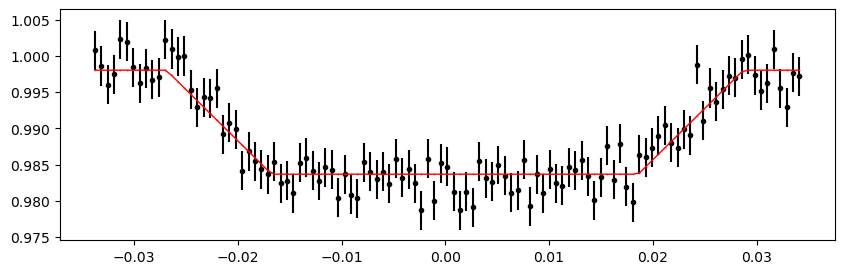

1863.024674 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:04<00:00, 155.01it/s]


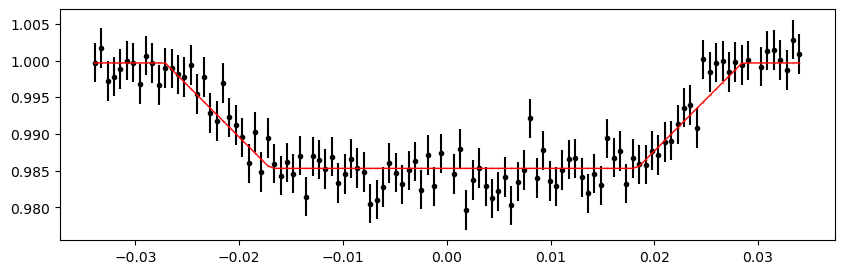

1865.27496 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:03<00:00, 158.49it/s]


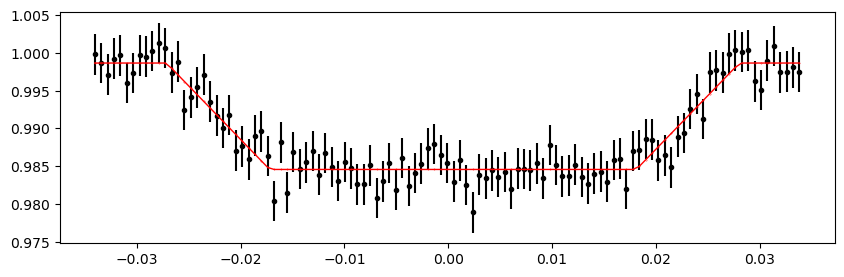

1867.525246 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.96it/s]


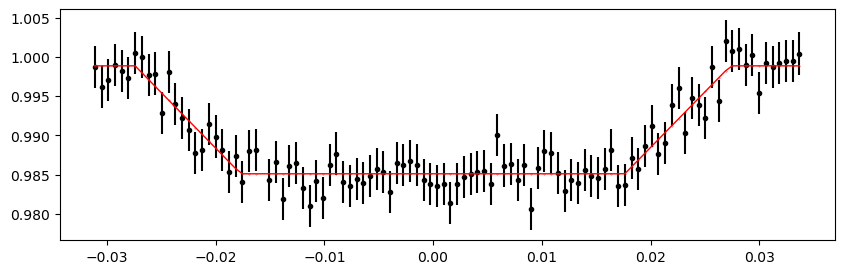

2502.105898 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.10it/s]


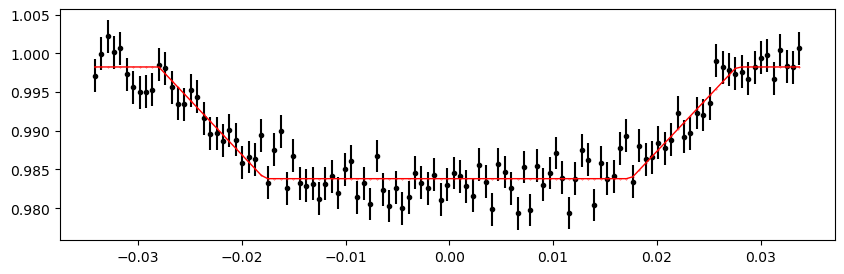

2504.3561839999998 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.02it/s]


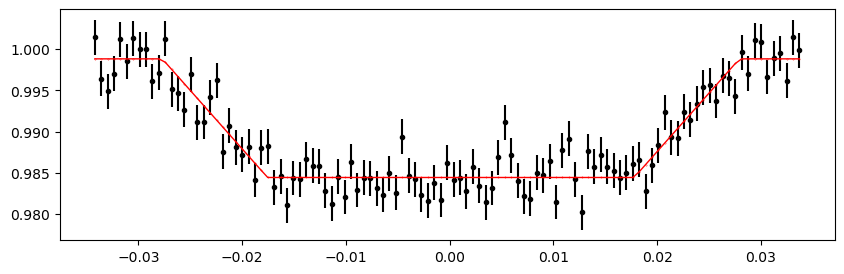

2506.6064699999997 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.42it/s]


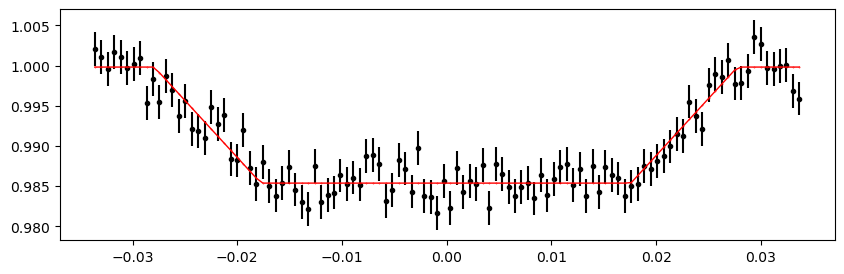

2508.856756 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.21it/s]


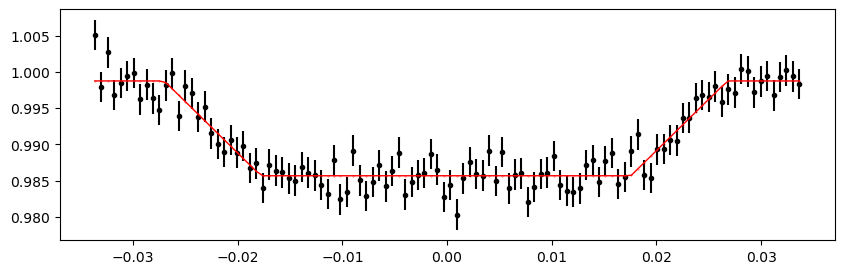

2511.1070419999996 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.08it/s]


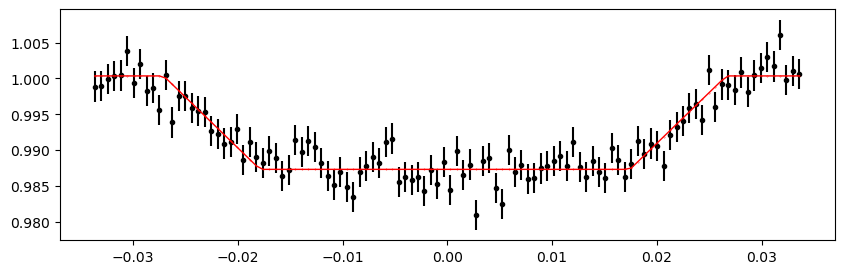

2515.607614 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.81it/s]


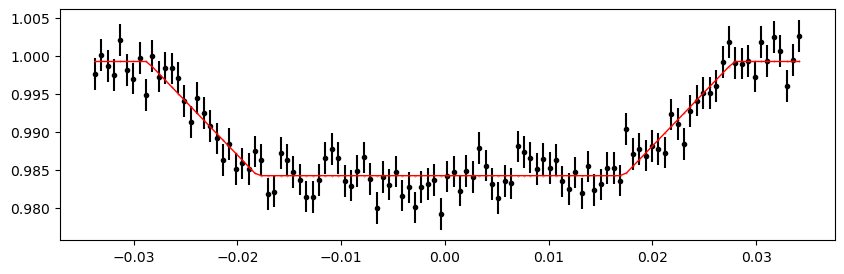

2517.8579 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.39it/s]


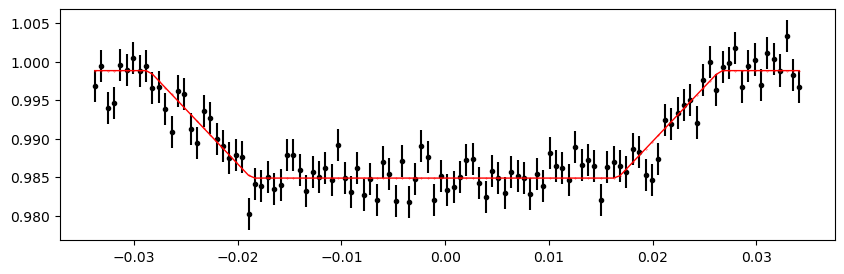

2520.108186 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.12it/s]


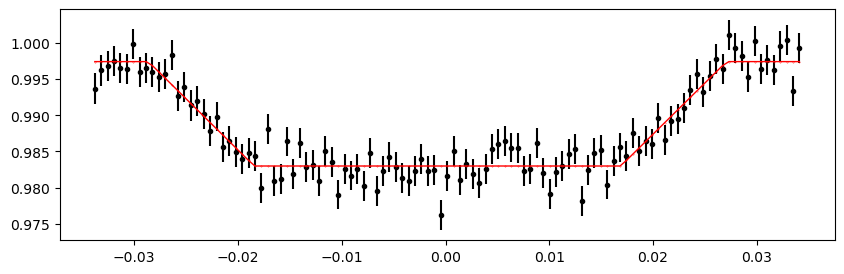

2522.358472 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.85it/s]


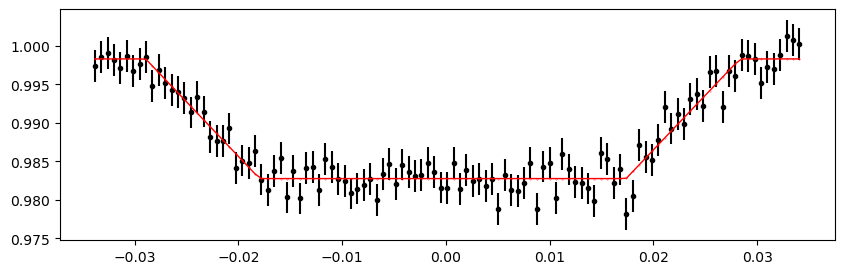

2526.859044 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.29it/s]


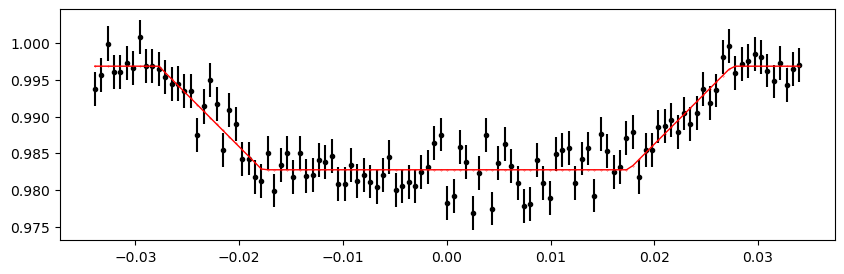

2529.1093299999998 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.04it/s]


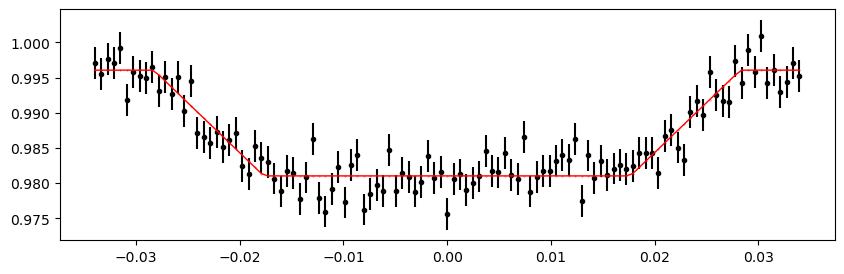

2531.3596159999997 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.73it/s]


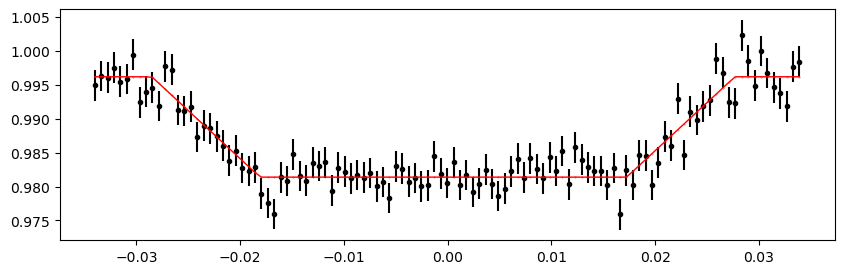

2533.609902 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.32it/s]


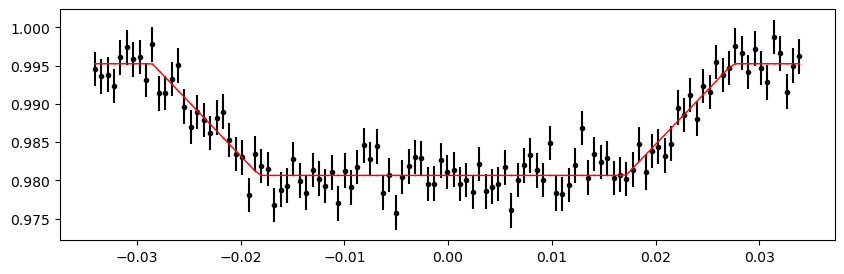

2535.8601879999997 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.20it/s]


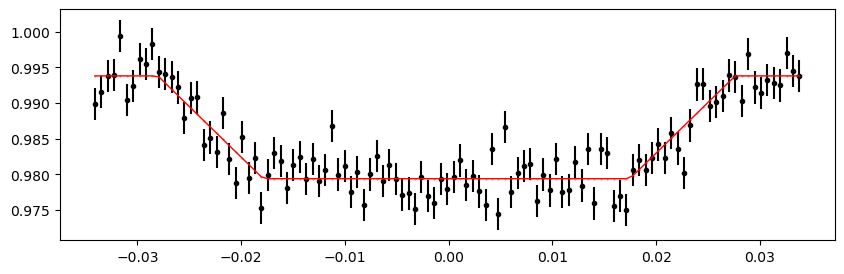

2542.611046 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.99it/s]


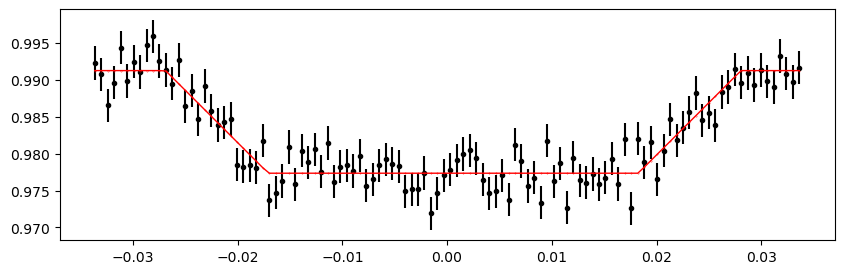

2544.861332 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.20it/s]


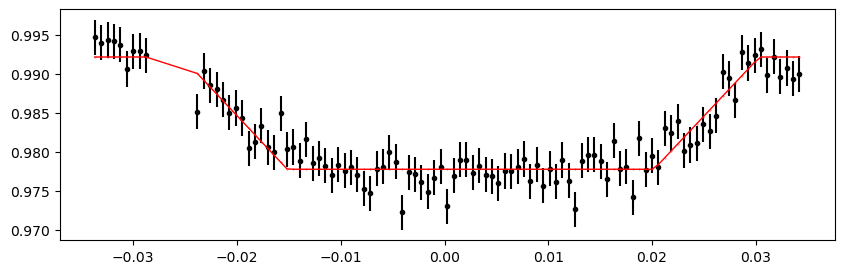

2547.111618 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.32it/s]


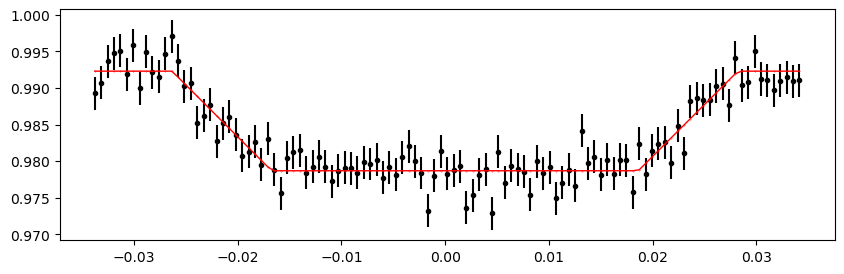

2549.361904 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.09it/s]


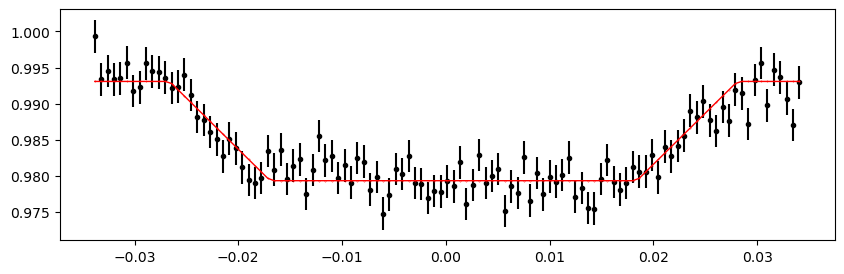

2580.8659079999998 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.09it/s]


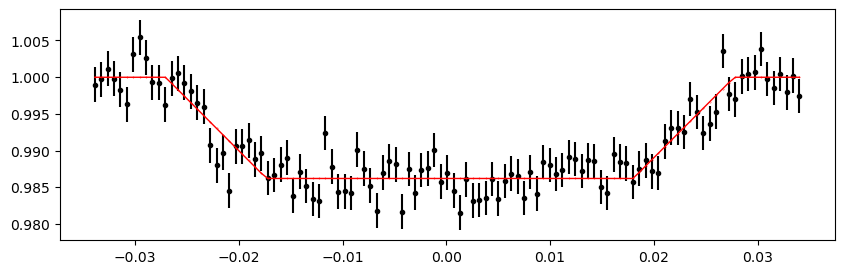

2583.116194 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.53it/s]


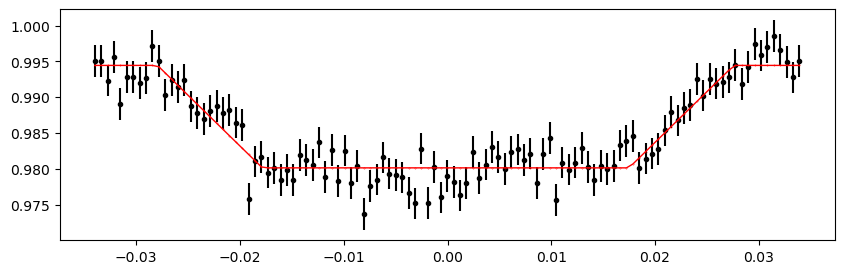

2585.3664799999997 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.02it/s]


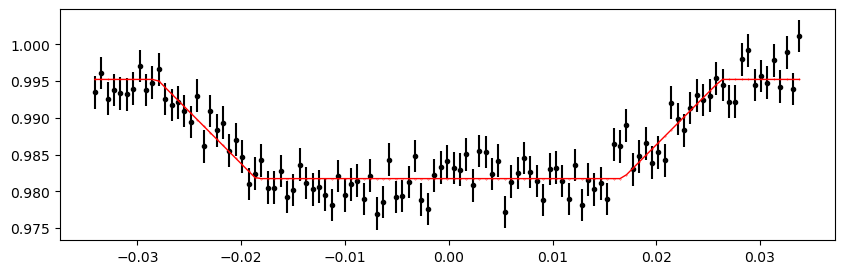

2587.616766 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.49it/s]


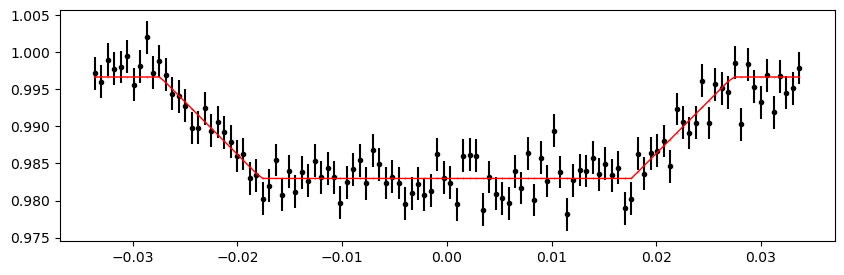

2589.867052 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.31it/s]


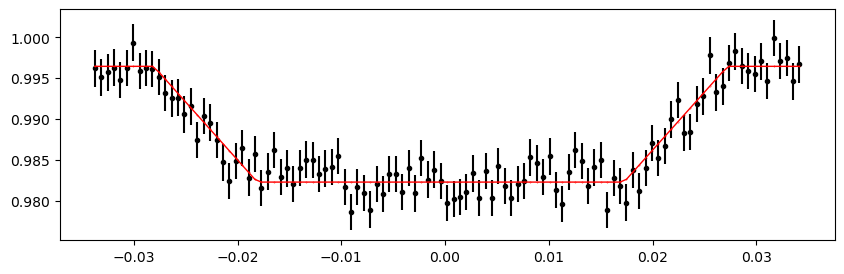

2592.117338 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:05<00:00, 152.89it/s]


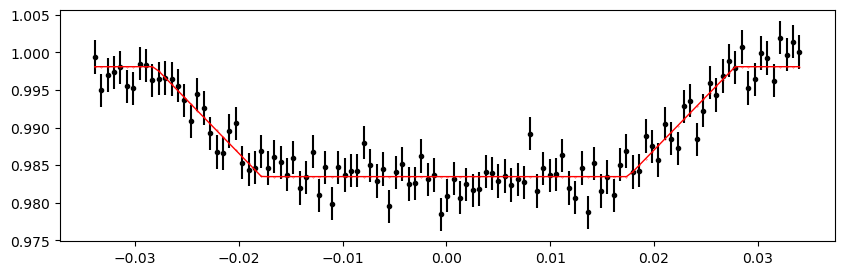

2596.61791 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.79it/s]


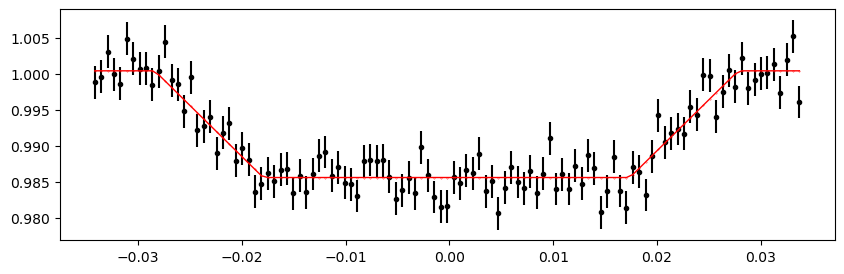

2598.868196 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.92it/s]


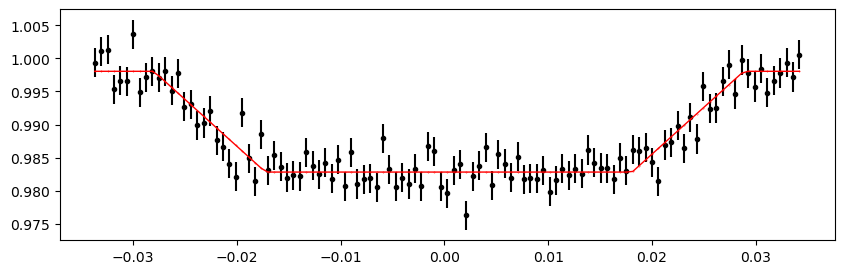

2601.118482 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.04it/s]


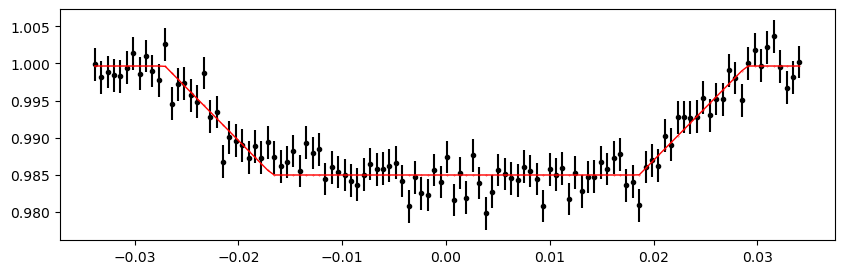

2603.368768 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.47it/s]


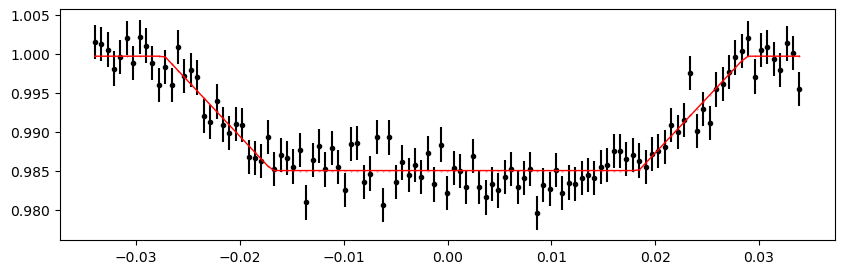

2605.619054 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.26it/s]


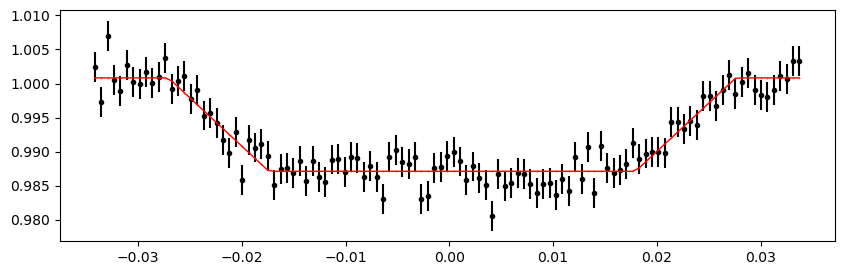

2940.9116679999997 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 159.86it/s]


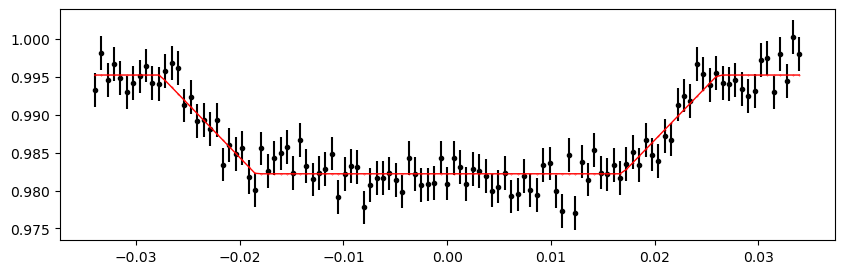

2943.161954 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.03it/s]


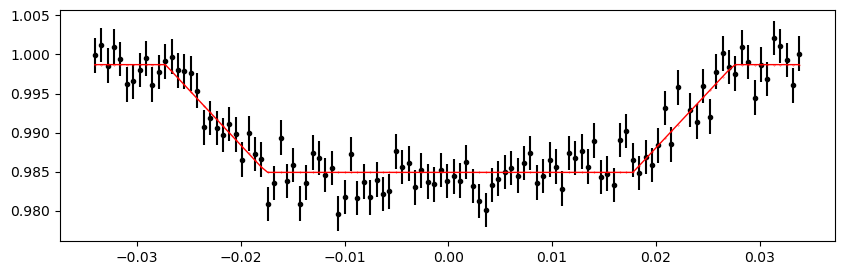

2945.4122399999997 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.08it/s]


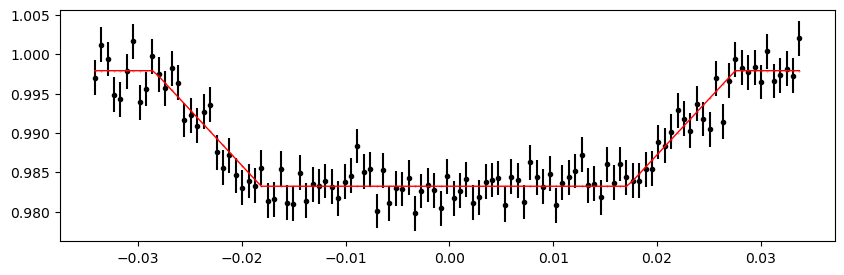

2947.662526 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.82it/s]


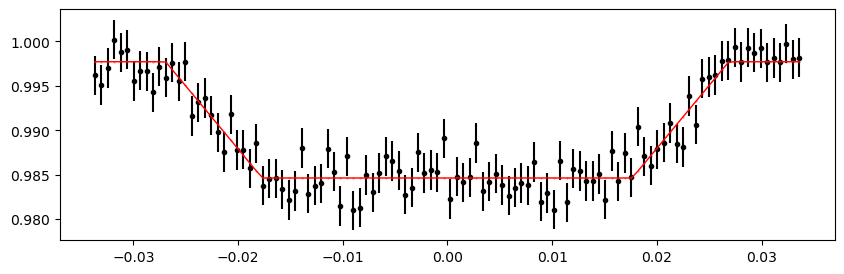

2956.66367 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.06it/s]


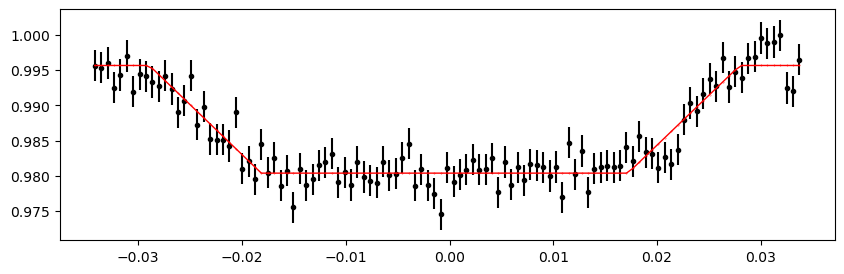

2958.913956 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.72it/s]


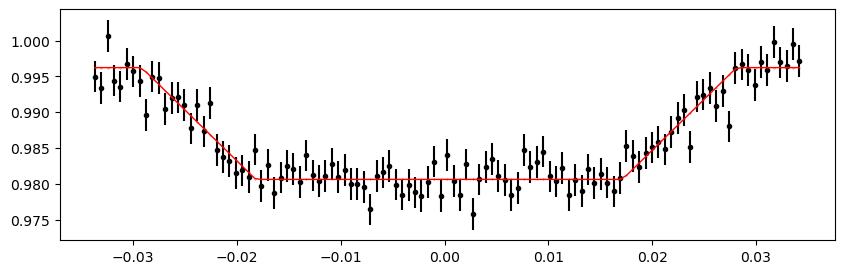

2961.164242 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.22it/s]


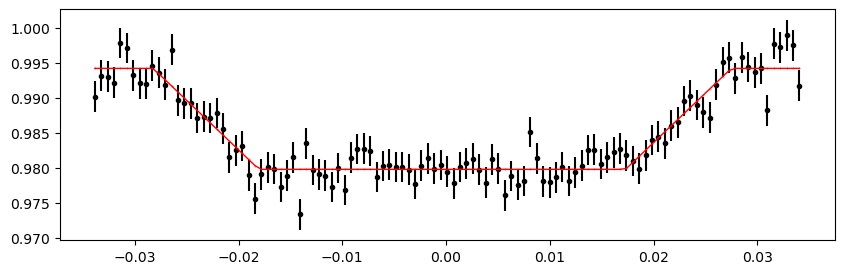

3235.699134 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.64it/s]


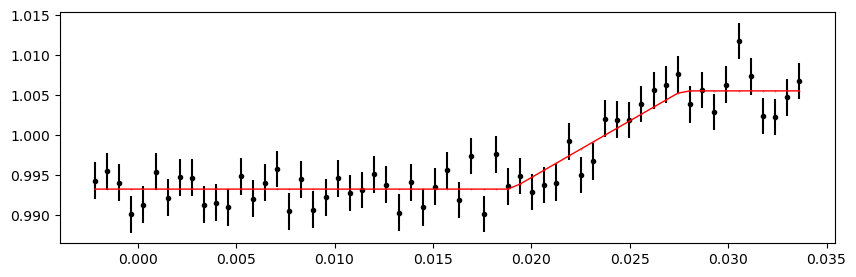

3237.94942 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.32it/s]


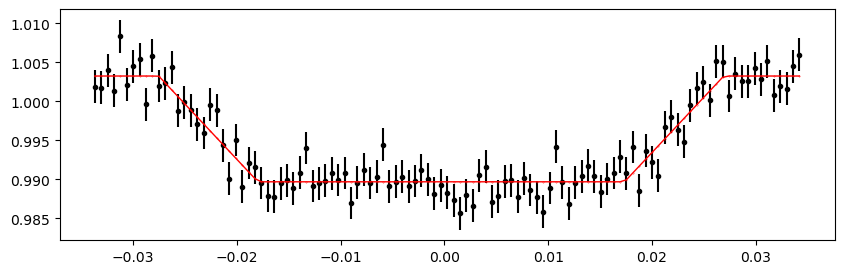

3240.199706 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 162.07it/s]


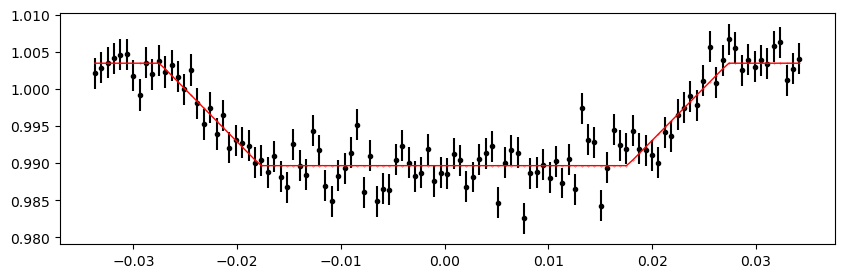

3242.449992 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.86it/s]


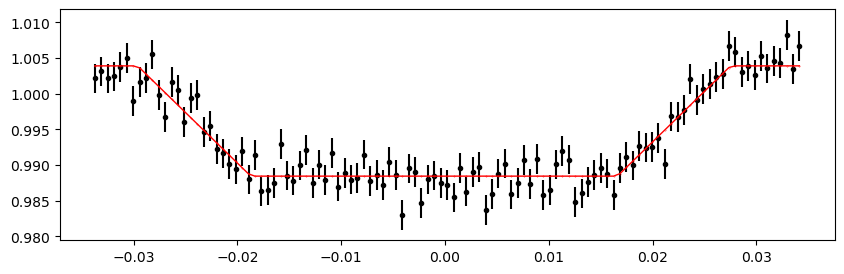

3244.7002780000003 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.46it/s]


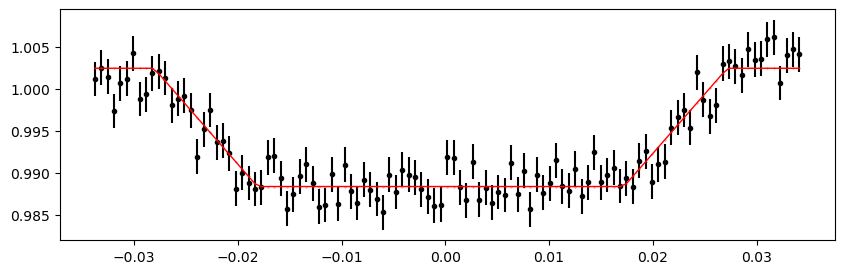

3251.4511359999997 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.31it/s]


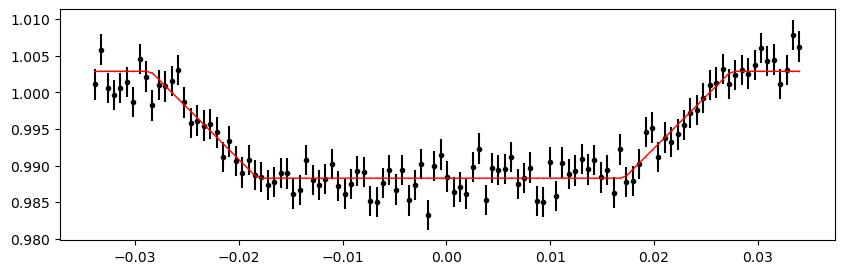

3253.701422 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.28it/s]


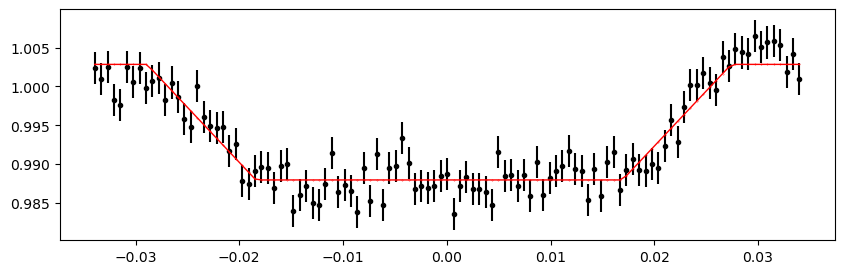

3255.9517079999996 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.71it/s]


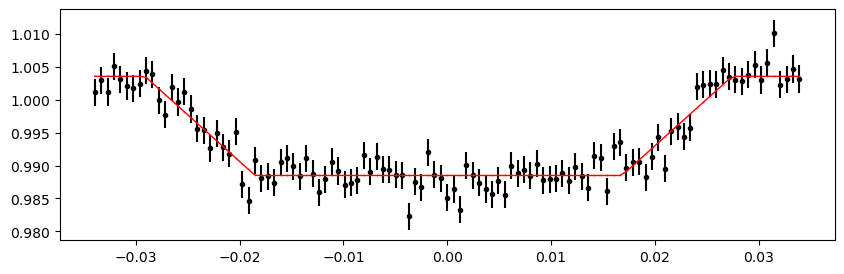

3258.201994 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.81it/s]


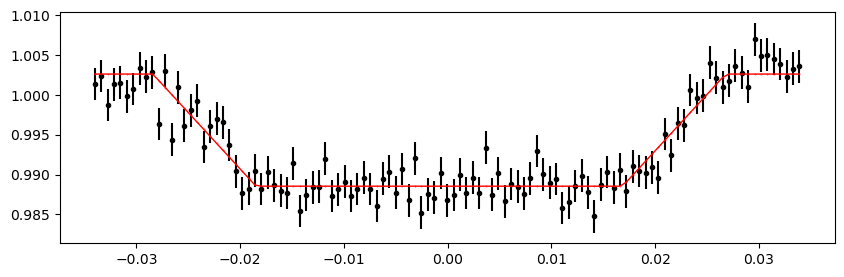

3262.702566 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 159.74it/s]


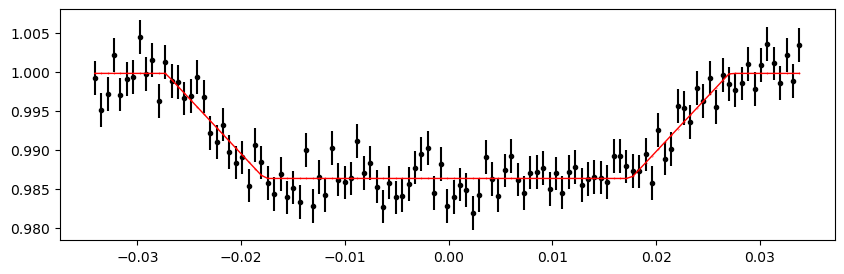

3264.952852 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 159.52it/s]


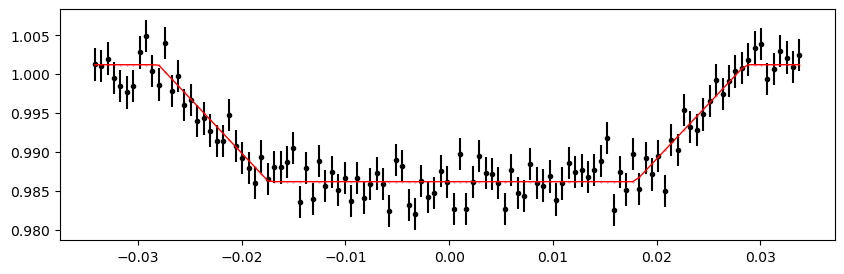

3267.203138 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.39it/s]


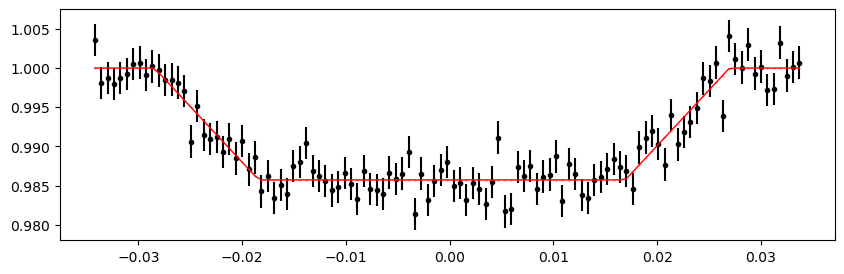

3269.453424 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.10it/s]


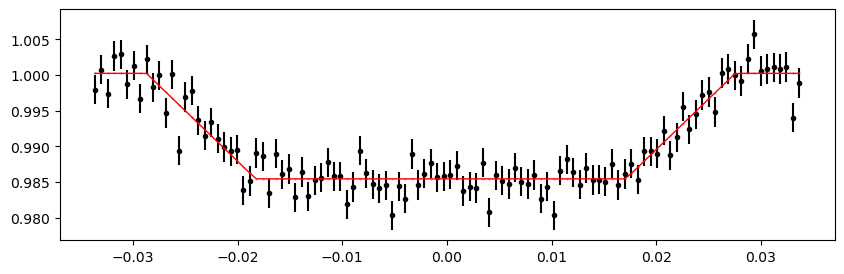

3271.70371 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.49it/s]


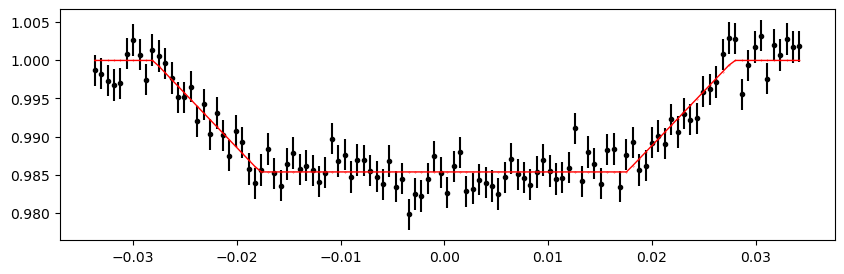

3276.2042819999997 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 160.26it/s]


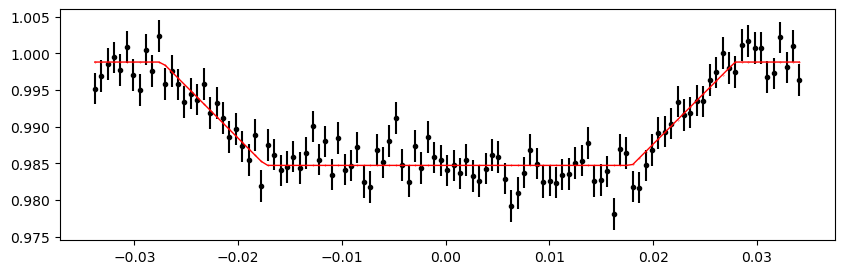

3278.454568 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.42it/s]


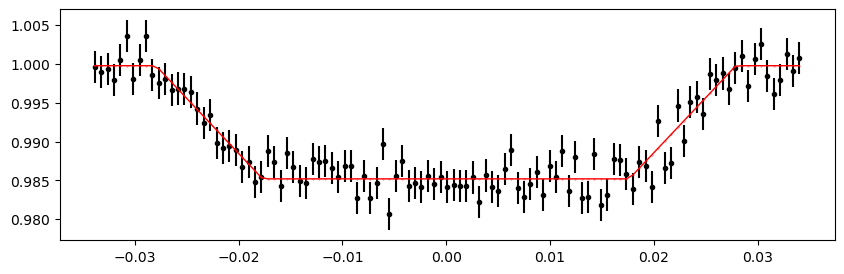

3280.7048539999996 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 161.30it/s]


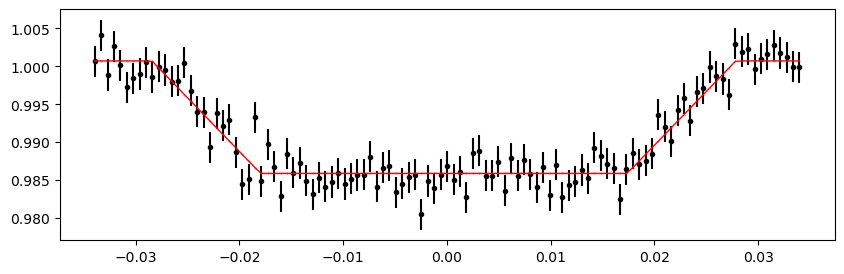

3282.95514 0.9986928039394569 0.014292437687910782 0


100%|███████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.25it/s]


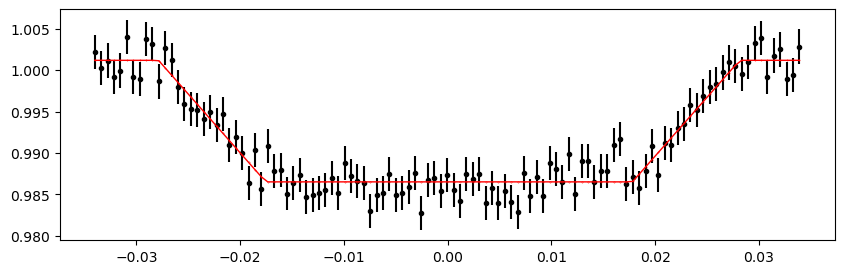

In [54]:
%matplotlib inline

# from importlib import reload
reload(etv_functions)
reload(etv_functions_trapezoid)

print("Fitting individual primary eclipses...")
etv_functions_trapezoid.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_val_constant, mean_amplitude, mean_t0, mean_bottom_width, mean_slope, outfile_path,
                               min_number_data=20, 
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


In [ ]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions_trapezoid.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_val_constant_s, mean_amplitude_s, mean_t0_s, mean_bottom_width_s, mean_slope_s, outfile_path_s,
                                   min_number_data=20, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

Note: 1 data points in df_primary filtered out due to huge O-C error.


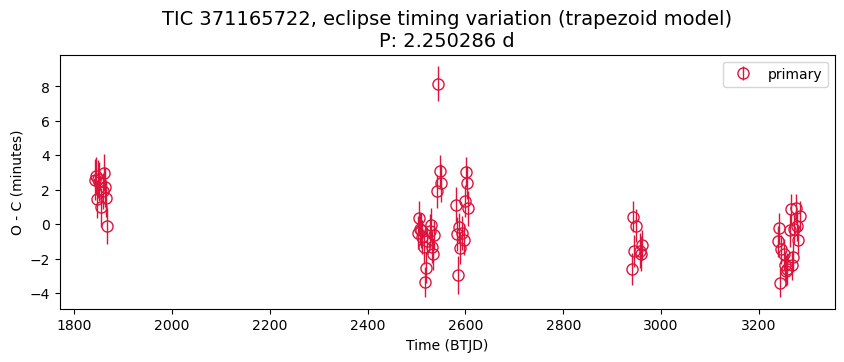

In [62]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation (trapezoid model)"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

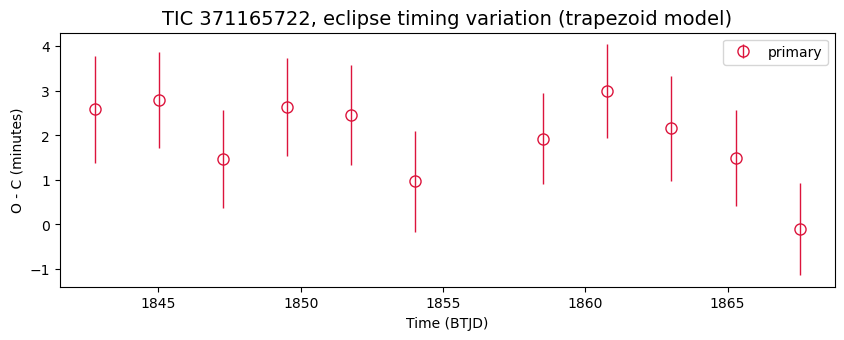

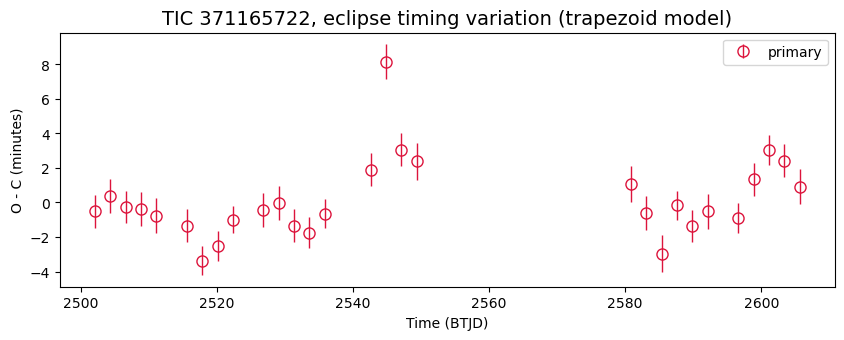

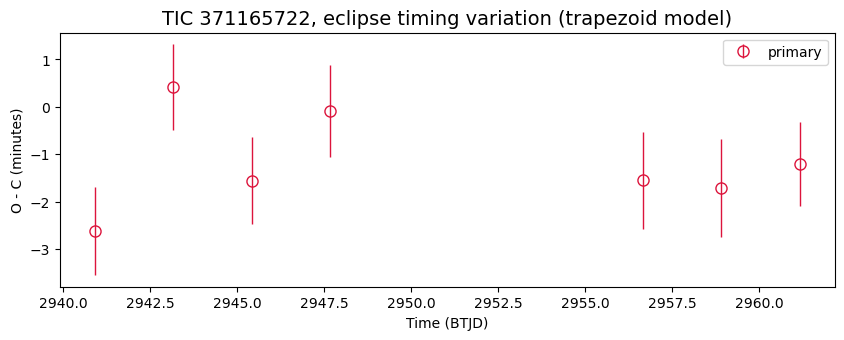

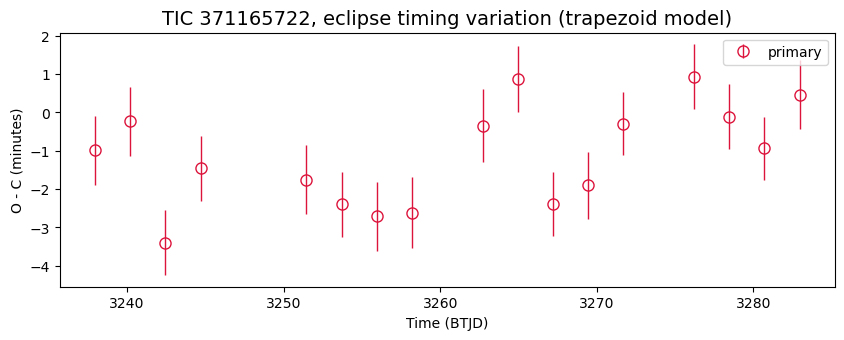

In [63]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1800, 1900),
    (2500, 2700),
    (2900, 3000),
    (3200, 3400),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

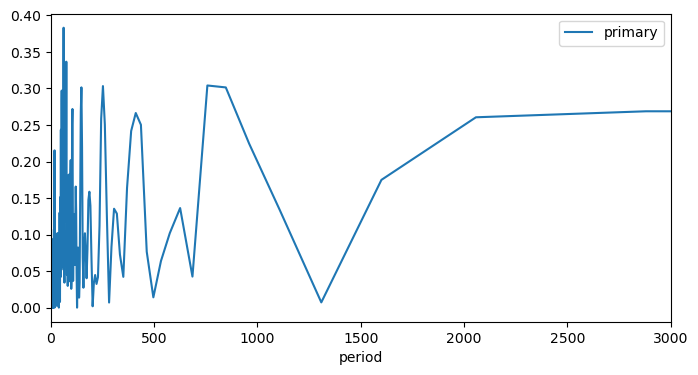

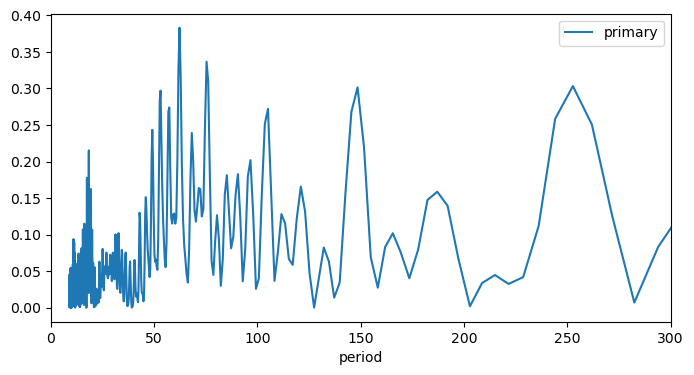

In [64]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 3000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 300)
    plt.show()

## Results Summary

In [66]:
# FILL-IN the ETV results / comments
has_etv = "?"
comments = "Scattered O-C, with range of < 10 min from trapezoid model. No apparent trend."

# Eclipse depth from the model
depth_pct_p = round(mean_amplitude * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(mean_amplitude_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

,0
tic,371165722
has_etv,?
comments,"Scattered O-C, with range of < 10 min from trapezoid model. No apparent trend."
period,2.250286
depth_pct_p,1.43
depth_pct_s,None
epoch_p,1842.7721
epoch_s,None
num_sectors,7
time_span,1443.08



tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
371165722,?,"Scattered O-C, with range of < 10 min from trapezoid model. No apparent trend.",2.250286,1.43,,1842.7721,,7,1443.08,1842.51,3285.59

